# Feature Analysis

### Initiate Environment

In [14]:
using Pkg
Pkg.activate(".")

using DataFrames
using Plots
using Statistics

using Revise
using TitanicClassifier

  Activating project at `~/CTU/SEM_5/JUL/TitanicClassifier/examples`


### Data Analysis

In [15]:
train = CSV_to_df("../data/train.csv");
test = CSV_to_df("../data/test.csv");
merged = vcat(select(train, Not("Survived")), test);
select!(merged, Not("PassengerId"));

Taking first look at the structure of our data. Our goal is to predict the Survived feature based on the input of the other features. We can see that these features entail a mixture of numerical features (Pclass, SibSp, Parch, Fare, Age), 
categorical features (Sex, Embarked), and features which fit neither category (Name, Ticket, Cabin). In order to apply SVM algorithm to our problem, we need to transform all features to numeric values.

In [16]:
print(select(first(train, 10), Not("PassengerId")))

10×11 DataFrame
 Row │ Survived  Pclass  Name                               Sex      Age        SibSp  Parch  Ticket            Fare     Cabin     Embarked 
     │ Int64     Int64   String                             String7  Float64?   Int64  Int64  String31          Float64  String15  String1  
─────┼──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │        0       3  Braund, Mr. Owen Harris            male          22.0      1      0  A/5 21171          7.25    missing   S
   2 │        1       1  Cumings, Mrs. John Bradley (Flor…  female        38.0      1      0  PC 17599          71.2833  C85       C
   3 │        1       3  Heikkinen, Miss. Laina             female        26.0      0      0  STON/O2. 3101282   7.925   missing   S
   4 │        1       1  Futrelle, Mrs. Jacques Heath (Li…  female        35.0      1      0  113803            53.1     C123      S
   5 │        0       3  Alle

We can further note that some of the features have missing values. These missing values need to be imputed if we want to use them in training of our SVM classifier. Let's take a look at which features miss value and how many. 

In [17]:
incomplete_cols = Dict()

for row in eachrow(merged)
    for name in names(merged)
        if(ismissing(row[name]))
            incomplete_cols[name] = get!(incomplete_cols, name, 0) + 1
        end
    end
end

for entry in incomplete_cols
    print("Missing ", entry[2], " out of ", nrow(merged), " entries (", round(entry[2]/nrow(merged); sigdigits=2), "%) for feature ", entry[1], "\n")
end

Missing 1 out of 1309 entries (0.00076%) for feature Fare
Missing 263 out of 1309 entries (0.2%) for feature Age
Missing 2 out of 1309 entries (0.0015%) for feature Embarked
Missing 1014 out of 1309 entries (0.77%) for feature Cabin


We can view the value distribution of our numeric features.

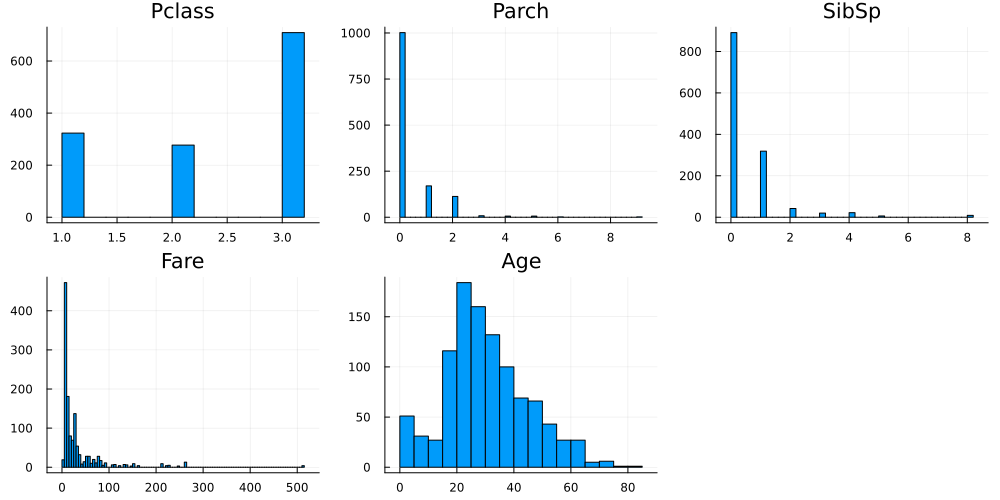

In [18]:
temp = [merged[!, "Pclass"], merged[!, "Parch"], merged[!, "SibSp"], merged[!, "Fare"], skipmissing(merged[!, "Age"])]

histogram(temp, layout=5, size=(1000,500), legend=false, visible=true, title=["Pclass" "Parch" "SibSp" "Fare" "Age"])

I'd like to convert features which are neither numeric nor categorical into categorical features, however we can see below that their values are largely unique (Cabin has a lot of missing values), therefore these features need further preprocessing.

In [19]:
uq_name = nrow(combine(groupby(merged, "Name"), nrow => :count))
uq_ticket = nrow(combine(groupby(merged, "Ticket"), nrow => :count))
uq_cabin = nrow(combine(groupby(merged, "Cabin"), nrow => :count))
print("Unique name count ", uq_name, "\nUnique ticket count ", uq_ticket, "\nUnique cabin count ", uq_cabin)

Unique name count 1307
Unique ticket count 929
Unique cabin count 187

### Data Preprocessing

 Since columns Sex, and Embarked are non numeric, yet categorical features, I've chosen such conversion from categorical to numeric feature that I assign the categories integers 1 to n, where n is the number of categories for the respective columns. Moreover I've decided to leave the already numeric features untouched in terms of preprocessing. Columns Name, Ticket, and Cabin have to undergo more sophisticated transformation. From the Name feature I've decided to use only the person's title, since that's the infromation most readily extracted, and I group these titles into categories, which gives us a categorical feature, which I then again transform into numeric feature. Similarly I extract the deck from the Cabin feature, and transform it into a numeric feature. I assign an unknown token to rows with missing Cabin feature, which has proven to be quite efficient in terms of training the classifier, since one of the sources for the Cabin feature is recollection of the survivors. Lastly I use the ticket number extracted from the Ticket feature, which I then sort and use the index of the ticket number in this sorted array (I wanted to preserve the information about passengers traveling with the same ticket, and make the numeric range more manageable).

In [20]:
merged_copy = copy(merged)

name_to_title!(merged_copy)

print(combine(groupby(merged_copy, [:Name]), nrow))

18×2 DataFrame
 Row │ Name       nrow  
     │ SubStrin…  Int64 
─────┼──────────────────
   1 │ Mr           757
   2 │ Mrs          197
   3 │ Miss         260
   4 │ Master        61
   5 │ Don            1
   6 │ Rev            8
   7 │ Dr             8
   8 │ Mme            1
   9 │ Ms             2
  10 │ Major          2
  11 │ Lady           1
  12 │ Sir            1
  13 │ Mlle           2
  14 │ Col            4
  15 │ Capt           1
  16 │ Countess       1
  17 │ Jonkheer       1
  18 │ Dona           1

Above we can see all the titles from the dataset and their frequencies. Closer inspection of the titles reveals that a lot of them bear similarities with one another and their holders would be presumably treated the same way on the Titanic, therefore in an attempt to generalise these titles, I've grouped these titles into "office" tokens which can be seen below.

In [21]:
title_to_title_token!(merged_copy)
print(combine(groupby(merged_copy, [:Name]), nrow))

6×2 DataFrame
 Row │ Name       nrow  
     │ Abstract…  Int64 
─────┼──────────────────
   1 │ Mr           757
   2 │ Mrs          198
   3 │ Miss         264
   4 │ Master        61
   5 │ Royalty        6
   6 │ Officer       23

### Imputing Missing Data

Since the amount of missing data for Fare and Embarked is low, I impute the missing data with median for Fare (as it is robust with regards to outliers), and the most common value for Embarked. Furthermore I impute Age using linear regression with the closed form solution for features which correlate with Age the most, which can be seen in the correlation matrix below to be Pclass and Title features (Title is Name after preprocessing).

In [22]:
processed_data = copy(merged)

cabin_preprocessing!(processed_data)
name_preprocessing!(processed_data)
ticket_preprocessing!(processed_data)
replace_missing_with_median!(processed_data, [:Fare])
replace_missing_with_most_common!(processed_data, [:Embarked])
categorical_to_int!(processed_data, [:Sex, :Name, :Embarked, :Cabin])

display(DataFrame(cor(Matrix(dropmissing(processed_data))), ["Pclass", "Title", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]))

Row,Pclass,Title,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,-0.106179,-0.144695,-0.408106,0.0472215,0.0172239,0.400403,-0.565332,-0.550564,-0.112651
2,-0.106179,1.0,0.487575,-0.232343,0.265227,0.239834,-0.0314443,0.135823,0.0951708,0.113492
3,-0.144695,0.487575,1.0,-0.0636449,0.0952669,0.221144,-0.0763383,0.188155,0.111296,0.108484
4,-0.408106,-0.232343,-0.0636449,1.0,-0.243699,-0.150917,-0.139999,0.177528,0.196669,0.0474103
5,0.0472215,0.265227,0.0952669,-0.243699,1.0,0.374456,-0.0088227,0.141363,-0.0351648,-0.0301836
6,0.0172239,0.239834,0.221144,-0.150917,0.374456,1.0,-0.0393507,0.216872,0.0494717,-0.035567
7,0.400403,-0.0314443,-0.0763383,-0.139999,-0.0088227,-0.0393507,1.0,-0.229437,-0.200546,-0.157005
8,-0.565332,0.135823,0.188155,0.177528,0.141363,0.216872,-0.229437,1.0,0.378147,0.171496
9,-0.550564,0.0951708,0.111296,0.196669,-0.0351648,0.0494717,-0.200546,0.378147,1.0,0.0975172


Here we can see what the data looks like after preprocessing.

In [23]:
replace_missing_with_linreg!(processed_data, "Age", ["Name", "Pclass"])

display(first(processed_data, 10))

Row,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64?,Int64,Int64
1,3,1,1,22.0,1,0,299,7.25,1,1
2,1,2,2,38.0,1,0,261,71.2833,2,2
3,3,3,2,26.0,0,0,896,7.925,1,1
4,1,2,2,35.0,1,0,464,53.1,2,1
5,3,1,1,35.0,0,0,846,8.05,1,1
6,3,1,1,28.0842,0,0,591,8.4583,1,3
7,1,1,1,54.0,0,0,232,51.8625,3,1
8,3,4,1,2.0,3,1,752,21.075,1,1
9,3,2,2,27.0,0,2,688,11.1333,1,1
